#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.54227038,  0.78235121, -0.30638118],
       [-0.65928281,  0.62225706,  0.4220691 ],
       [ 0.52085413, -0.02688372,  0.85322227]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002303


In [33]:
Ret.shape

(50, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000354


In [37]:
C1(dx,dy,dz,Ret)

array([[-7.24012495e-03, -7.84455130e-01, -1.18871366e+00,
        -8.40353737e-03, -3.83295474e+00,  8.02243611e-01,
        -1.57108829e+00,  1.45269364e+00, -3.24435996e+00,
         5.54587332e-01, -2.38223855e+00,  1.61983921e+00,
         3.82921052e-01, -8.55776199e-01, -3.02108806e-01,
        -3.18457320e-01, -7.34242985e-01, -3.86459344e-02,
        -2.88605596e-01,  8.96156459e-02, -9.45840177e-01,
        -4.05933183e+00, -5.11497443e-01,  6.41898368e-02,
         9.65886622e-02,  2.15841276e-02,  3.23244855e-03,
        -2.33354735e-02, -3.84360183e-02, -2.17793513e-01,
         4.72072305e-03,  2.61905258e+00,  3.34842160e-01,
         6.82841787e-01,  9.21608847e-01,  1.64279285e-01,
         2.42813662e-01, -3.27621827e-02,  1.97810096e+00,
         1.53749763e-01,  1.02645257e-02,  9.15996513e-01,
        -1.32527340e+00,  1.86879486e+00,  2.09900952e+00,
         1.00941794e+00,  9.83307958e-02, -1.02537362e+00,
        -1.33885497e-01,  1.73065058e-01],
       [-1.07

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[-4.15513228e+01, -6.19008491e+03, -3.58568835e+03],
       [-4.50201461e+03,  1.47432418e+03, -1.34844591e+03],
       [-6.82206805e+03,  1.46812962e+03,  3.59301411e+02],
       [-4.82281862e+01, -3.71495408e+01, -6.53485128e+03],
       [-2.19974574e+04, -9.38190864e+01,  7.85274656e+01],
       [ 4.60410331e+03, -1.47417843e+04,  3.05542218e+03],
       [-9.01652900e+03,  3.04547385e+02,  4.99324812e+02],
       [ 8.33705810e+03, -1.07628514e+03,  2.44976460e+04],
       [-1.86194919e+04, -1.28924562e+03, -3.13421711e+02],
       [ 3.18279552e+03,  4.87418367e+03,  5.78057561e+03],
       [-1.36717479e+04, -1.08136661e+04, -5.98550816e+03],
       [ 9.29631221e+03, -2.02026467e+03, -8.69330905e+02],
       [ 2.19759691e+03,  2.15952283e+04, -2.38799329e+02],
       [-4.91132865e+03, -3.89437939e+03,  3.50551912e+03],
       [-1.73381269e+03,  2.05416267e+02, -1.70969333e+03],
       [-1.82763737e+03,  5.64100108e+03,  3.35089972e+03],
       [-4.21384541e+03, -7.72992279e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.004795


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000376


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR) 

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000026


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[-1.03003242,  0.19333448,  0.19823807],
       [-1.49131247,  0.51162387,  0.58037518],
       [ 1.11256393,  0.95282702,  0.23146074],
       [ 0.28083135,  0.59089283,  0.33330204],
       [ 0.89246184, -0.86858918, -0.61175748],
       [-0.60989976,  0.32011115, -0.25813087],
       [ 0.01741038,  2.43445045,  1.14336129],
       [ 0.11277817,  1.93768214,  1.05353459],
       [ 0.70659995,  0.06467451, -0.02553145],
       [-2.6685651 ,  2.6049244 ,  1.20442014],
       [ 1.86268818, -1.66083372, -1.33202646],
       [ 0.75357834, -0.64692268,  1.47071277],
       [-0.43349103,  0.99737986,  0.50157859],
       [ 0.692216  , -0.08564113, -1.14233701],
       [-1.01486026, -1.63668013, -0.51449567],
       [ 0.05977425,  0.87240587, -1.83139911],
       [ 1.62920717, -0.24518513, -0.74822596],
       [ 0.20423001, -0.51739533, -0.88940622],
       [-0.65154936,  0.38741005,  1.30562519],
       [-0.75961584,  0.91348198, -0.40441807],
       [-0.36746254,  0.40373535, -0.173

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000153


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000533


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000538


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[-1.03932664, -0.33252105, -0.15241095],
       [-0.16060811, -0.68843042, -0.84202091],
       [ 0.8462942 ,  0.91502659,  1.6705639 ],
       [ 1.08784276, -0.46951876,  2.09102679],
       [-0.74234826,  0.57242957,  0.47765879],
       [ 0.22669463,  1.32513538, -0.79569057],
       [ 0.28897991,  0.02328671,  0.37262619],
       [-0.70522956,  0.56275629,  0.31373567],
       [ 0.90966402,  0.70368255, -0.49172318],
       [-1.01318899,  0.44520422,  1.12142909],
       [-0.44076343, -0.99687871, -2.71423095],
       [ 0.86945658,  0.84289116, -0.12053934],
       [-0.31427555, -1.76555177, -1.61847014],
       [ 1.30625226,  1.42937569, -0.84187591],
       [-0.02088369, -1.88114938,  0.38955024],
       [ 0.05894996,  1.29477816, -1.1086552 ],
       [-1.37679303, -0.66219132,  0.85154379],
       [-0.03407134,  0.82985241,  1.44075467],
       [-0.82098225, -0.28337187, -0.28038017],
       [ 1.9609428 ,  0.03392487, -0.21604968],
       [-0.22398511, -0.17231011,  0.857

In [63]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 5.42141539e-05,  6.45534448e-04, -6.44385116e-03,
        -2.28795773e-03,  2.26665530e-03, -5.18846200e-03,
        -1.14951061e-02, -7.85783789e-03, -8.08634046e-04,
        -1.24711418e-02,  2.87327540e-03,  1.90285388e-02,
        -4.41106883e-03, -9.51648552e-03,  1.00162503e-02,
        -2.42932922e-02, -4.54098083e-03, -3.37567664e-03,
         8.28565182e-03, -1.18156988e-02, -5.17696907e-03,
        -1.60474874e-02,  2.70671361e-03, -4.71291040e-03,
        -1.41791107e-03, -7.08782124e-03,  4.95738341e-03,
         1.44412606e-02,  1.01921842e-02, -1.15304937e-02,
        -4.62427044e-03, -4.86876054e-04,  2.04098873e-02,
         2.61319790e-03, -1.00027504e-02, -9.39636859e-03,
        -2.36852505e-03,  2.62832955e-03, -1.44799135e-02,
        -6.86023014e-03,  1.21000470e-02,  4.03484467e-03,
        -1.54263784e-02,  5.96233589e-03, -1.71660008e-02,
         4.82078060e-03,  2.20475537e-03,  1.96920098e-03,
        -6.92531618e-03,  1.75473826e-02],
       [-2.90

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000862


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-5.77716918e-08, -7.94939394e-07, -6.75643942e-07,
         1.14159784e-06,  1.49718813e-06,  3.01997943e-07,
        -2.75614920e-06, -2.23625875e-06, -9.89412032e-07,
         1.80300879e-06,  2.72528132e-06,  9.01141641e-07,
        -1.15753399e-06, -1.44462425e-06,  1.66677182e-06,
        -2.07536486e-06, -2.75262531e-06, -9.66227141e-07,
        -1.09027405e-06,  7.68331540e-08, -9.36182648e-08,
        -1.82588511e-06, -7.23520414e-07, -5.59966946e-07,
         8.16154983e-08, -1.39637073e-06,  7.51914865e-07,
        -1.27016070e-07, -1.72753617e-06, -2.02314864e-06,
         5.83321211e-07,  2.05203466e-07,  2.19152087e-07,
        -4.75203262e-07,  1.89620361e-08, -3.78283623e-07,
        -7.58541010e-07, -3.60735028e-08,  3.07038196e-07,
        -1.82844179e-06,  5.65544510e-08,  1.01209904e-06,
        -3.41813770e-07, -2.43972663e-06, -1.88415991e-06,
         6.85533290e-07,  4.69219422e-07, -2.27770263e-06,
        -1.34761972e-06, -1.95501502e-06],
       [-2.16

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[ 4.15513228e+01,  4.50201461e+03,  6.82206805e+03,
         4.82281862e+01,  2.19974574e+04, -4.60410331e+03,
         9.01652900e+03, -8.33705810e+03,  1.86194919e+04,
        -3.18279552e+03,  1.36717479e+04, -9.29631221e+03,
        -2.19759691e+03,  4.91132865e+03,  1.73381269e+03,
         1.82763737e+03,  4.21384541e+03,  2.21790329e+02,
         1.65631731e+03, -5.14307233e+02,  5.42820887e+03,
         2.32966431e+04,  2.93550118e+03, -3.68387652e+02,
        -5.54325610e+02, -1.23872041e+02, -1.85511319e+01,
         1.33923075e+02,  2.20585614e+02,  1.24992436e+03,
        -2.70923898e+01, -1.50308316e+04, -1.92167052e+03,
        -3.91885219e+03, -5.28914445e+03, -9.42804389e+02,
        -1.39351585e+03,  1.88023278e+02, -1.13523885e+04,
        -8.82375106e+02, -5.89084616e+01, -5.25693507e+03,
         7.60578901e+03, -1.07250771e+04, -1.20462869e+04,
        -5.79308382e+03, -5.64323774e+02,  5.88465398e+03,
         7.68373411e+02, -9.93226243e+02],
       [ 6.19

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000940


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-1.48667109e+02,  9.11872182e+05,  5.89845422e+05],
       [-6.22181702e+02,  3.75434259e+06,  2.53044824e+06],
       [ 2.15510656e+01, -2.08365924e+05, -9.32204229e+03],
       [ 5.49074297e+01,  6.72426035e+05, -1.22710863e+06],
       [ 1.53062498e+02, -1.53862501e+06, -7.46094819e+03],
       [ 7.98955088e+01, -1.38567888e+04, -7.93208611e+05],
       [ 3.53124187e+02, -3.75965611e+05, -3.19110647e+06],
       [-7.41792452e-01, -1.38788809e+06,  1.39545165e+06],
       [ 1.24915039e+02, -1.28238505e+05, -1.13358680e+06],
       [ 6.61820155e-01, -7.75935689e+03,  1.07436038e+03],
       [-2.93959747e+02,  1.09740493e+06,  1.87197980e+06],
       [ 3.05931530e+02, -5.55166548e+05, -2.53517887e+06],
       [-2.76483167e-03,  1.76549525e+03, -1.73765571e+03],
       [ 1.92730144e+02, -2.40835619e+06,  4.61610774e+05],
       [-2.02491142e+02,  1.01249973e+06,  1.03291734e+06],
       [ 3.74818573e+01, -4.52070339e+04, -3.33414416e+05],
       [ 5.35835484e+01, -5.06182793e+05

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-7.26709907e+08,  5.89125979e+07, -9.12591588e+07],
       [-1.59458467e+08,  2.53029037e+08, -3.75450044e+08],
       [-1.59526450e+08, -9.47997350e+05,  2.08208001e+07],
       [-5.76122567e+08, -1.22767899e+08, -6.72996367e+07],
       [-5.93889220e+08, -8.04889862e+05,  1.53803709e+08],
       [-1.40388298e+07, -7.93222509e+07,  1.38428911e+06],
       [-7.76523487e+08, -3.19187523e+08,  3.75196891e+07],
       [-5.35326013e+08,  1.39492168e+08,  1.38735814e+08],
       [-2.67598551e+08, -1.13385172e+08,  1.27973596e+07],
       [-7.34614177e+08,  3.47092221e+04,  7.03212558e+05],
       [ 9.16018738e+08,  1.87288666e+08, -1.09649812e+08],
       [-1.52869234e+08, -2.53533021e+08,  5.55015215e+07],
       [ 7.25036567e+06, -1.73047785e+05, -1.75831775e+05],
       [ 2.33069931e+07,  4.61633848e+07,  2.40837926e+08],
       [ 2.78588003e+07,  1.03294492e+08, -1.01247215e+08],
       [-2.02761406e+07, -3.33434490e+07,  4.51869616e+06],
       [-6.85471388e+05, -3.50675354e+06

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000389


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000679


In [82]:
d_me_

array([[ 7.71803206e-03,  5.21354808e+02, -5.99345085e+02],
       [ 3.33985969e-02, -4.29570078e+02,  9.22152423e+01],
       [ 2.11295657e-03,  2.65914468e+02, -2.87272017e+02],
       [-1.37152165e-02,  5.14288155e+02, -3.75769679e+02],
       [-1.12372549e-02,  4.13762212e+02, -3.00269822e+02],
       [-4.35565275e-02,  5.61779183e+01,  3.83806380e+02],
       [ 1.37925500e-02, -8.31322925e+01, -5.61892179e+01],
       [-2.17894617e-02,  3.89677239e+02, -1.69590296e+02],
       [-1.40059144e-02,  3.79725801e+02, -2.38264015e+02],
       [-1.42578879e-04,  8.04445314e+02, -8.03045817e+02],
       [ 4.33357354e-03,  6.74655134e+01, -1.11244613e+02],
       [-2.49981953e-02,  1.72872542e+02,  7.96384740e+01],
       [-4.94828533e-04,  3.69047435e+01, -3.19080932e+01],
       [ 1.92858850e-02, -2.06994323e+02,  1.21880546e+01],
       [-7.34019559e-02, -1.31871887e+01,  7.54659203e+02],
       [-1.61744252e-02,  6.88837434e+01,  9.44990496e+01],
       [ 3.48128515e-02, -3.47497577e+02

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[ 4.15513228e+01,  4.50201461e+03,  6.82206805e+03,
         4.82281862e+01,  2.19974574e+04, -4.60410331e+03,
         9.01652900e+03, -8.33705810e+03,  1.86194919e+04,
        -3.18279552e+03,  1.36717479e+04, -9.29631221e+03,
        -2.19759691e+03,  4.91132865e+03,  1.73381269e+03,
         1.82763737e+03,  4.21384541e+03,  2.21790329e+02,
         1.65631731e+03, -5.14307233e+02,  5.42820887e+03,
         2.32966431e+04,  2.93550118e+03, -3.68387652e+02,
        -5.54325610e+02, -1.23872041e+02, -1.85511319e+01,
         1.33923075e+02,  2.20585614e+02,  1.24992436e+03,
        -2.70923898e+01, -1.50308316e+04, -1.92167052e+03,
        -3.91885219e+03, -5.28914445e+03, -9.42804389e+02,
        -1.39351585e+03,  1.88023278e+02, -1.13523885e+04,
        -8.82375106e+02, -5.89084616e+01, -5.25693507e+03,
         7.60578901e+03, -1.07250771e+04, -1.20462869e+04,
        -5.79308382e+03, -5.64323774e+02,  5.88465398e+03,
         7.68373411e+02, -9.93226243e+02],
       [ 6.19

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

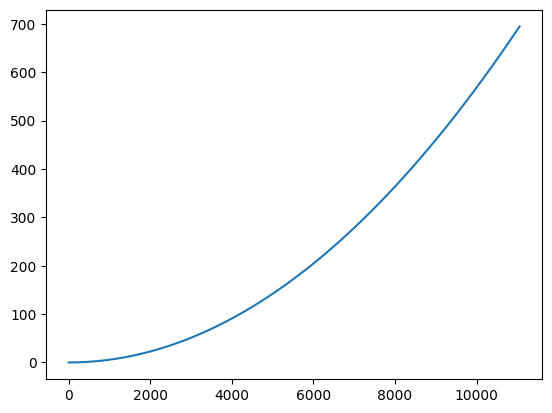

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    
    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 
    
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [101]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_25872/701681181.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(static_func, q0)


In [103]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
q0=root

In [106]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

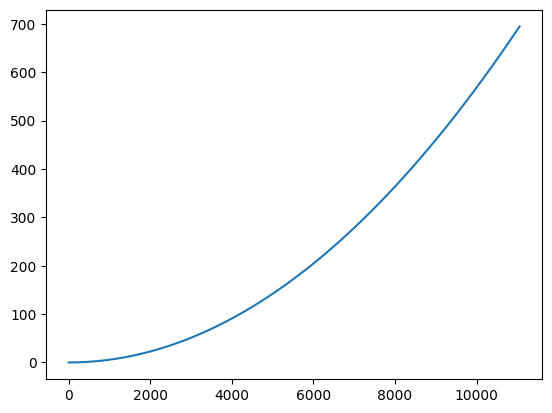

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force, 
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
    F = np.array(global_force)
    
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        global_force=[-10,0,20,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0])

In [113]:
d

array([-7.05147750e-06, -6.65367100e-08,  1.41769582e-05,  1.44778793e-06,
        1.74858422e-06,  1.13605431e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [114]:
f

array([-1.00000000e+01, -8.37864663e-16,  2.00000000e+01,  3.94129174e-15,
        1.01675929e-15, -7.91033905e-16,  9.87206850e+00, -3.05675021e-02,
       -1.07838097e-01, -2.02690310e-03, -1.73997236e-01,  2.99464928e-02,
        9.02939690e-02, -3.92960434e-02, -1.98477415e+01,  3.86750341e-02,
        1.23200864e-01, -1.59047604e-03,  3.76375299e-02,  6.98635455e-02,
       -4.44204429e-02, -9.64417725e-02, -1.83601343e-03, -8.72036301e-02])

In [115]:
def PipeForce(X,Y,Z,vessel_force, coef=1, E=210e9, G=84e9, A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2):
    coord=np.stack((X,Y,Z)).T 
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
        
    bc_node=list(range(6))
    bc_val=[0]*6
    global_force=np.zeros(len(X)*6) 
    global_force[-6:]=np.multiply(coef,np.array(vessel_force))

    d,f=FEA_u(coord,elcon,bc_node,bc_val,global_force,E,G,A,Iy,Iz,J)
    
    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])
        
    mom =[]   
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])
        
    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3]) 
    return np.array(fors), np.array(mom), np.array(angle)

In [116]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,[67067.8422171882,
                 8866784.826883841, 
                 136429924.3688211, 
                 760945444.8381816, 
                 -5770549859.826721, 
                 374662591.12388337],1e-10)

In [117]:
fors

array([[-6.84410122e-06, -8.86777229e-04, -1.36430674e-02],
       [ 8.54015525e-10,  2.02240737e-08,  9.34551991e-09],
       [ 2.36286724e-09, -6.67786337e-09,  7.04319802e-09],
       [ 3.12411430e-09,  2.56297377e-08, -3.48443052e-09],
       [ 4.30736691e-09,  2.32831887e-09, -1.21783614e-08],
       [ 5.52972779e-09, -6.91948721e-09,  9.43964551e-09],
       [ 4.59840521e-09, -1.25380959e-08,  3.18259481e-08],
       [ 5.29689714e-09,  4.37427054e-08,  8.70204531e-09],
       [ 3.60887498e-09, -3.58642893e-09,  9.26775101e-10],
       [ 4.65661287e-10, -8.08735479e-09,  2.36614142e-08],
       [-4.42378223e-09, -1.87963991e-08,  1.41153578e-08],
       [-4.07453626e-09,  4.20153638e-09,  2.13804014e-08],
       [-8.84756446e-09, -3.92375910e-10,  6.90488378e-09],
       [-7.91624188e-09, -3.89059096e-09, -3.68163455e-09],
       [-9.31322575e-09, -3.62950203e-09,  2.91038305e-10],
       [-1.23400241e-08, -3.17361945e-09, -2.03435775e-08],
       [-1.55996531e-08,  1.03237170e-08

### Vessle Simulation

In [118]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [119]:
vehicle=semisub('DPcontrol',2,0,40.0,0,0) 

In [120]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [121]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

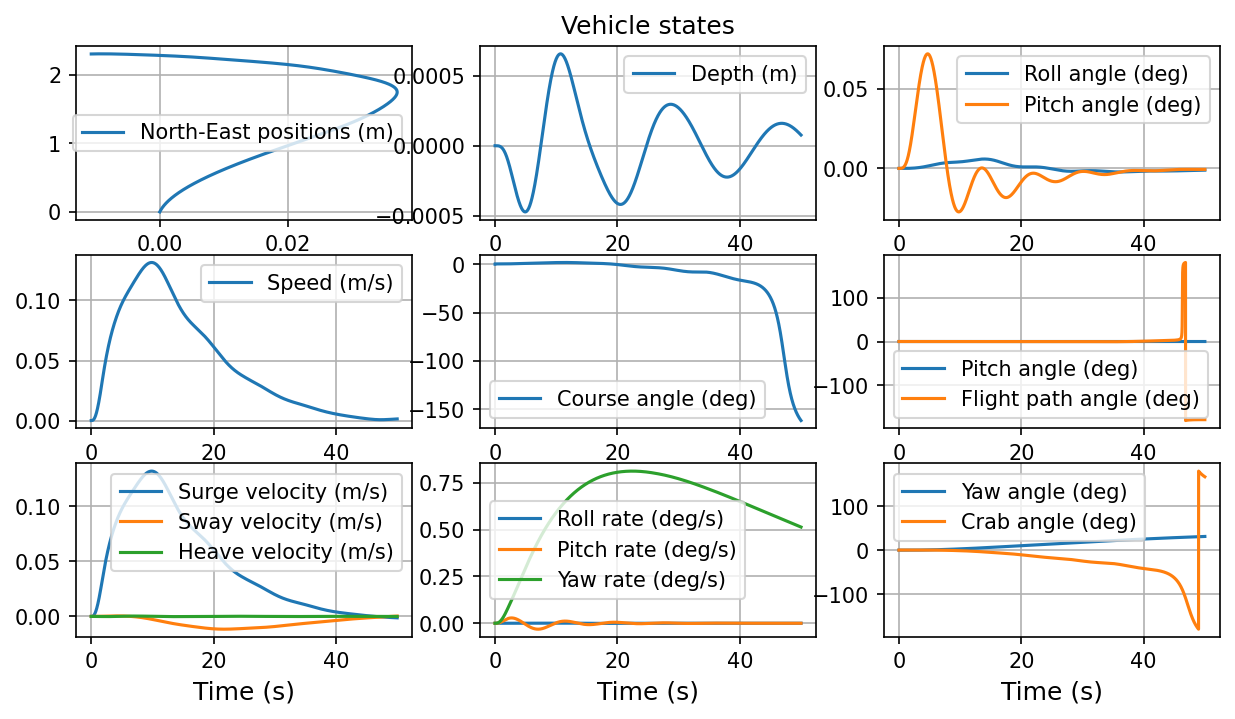

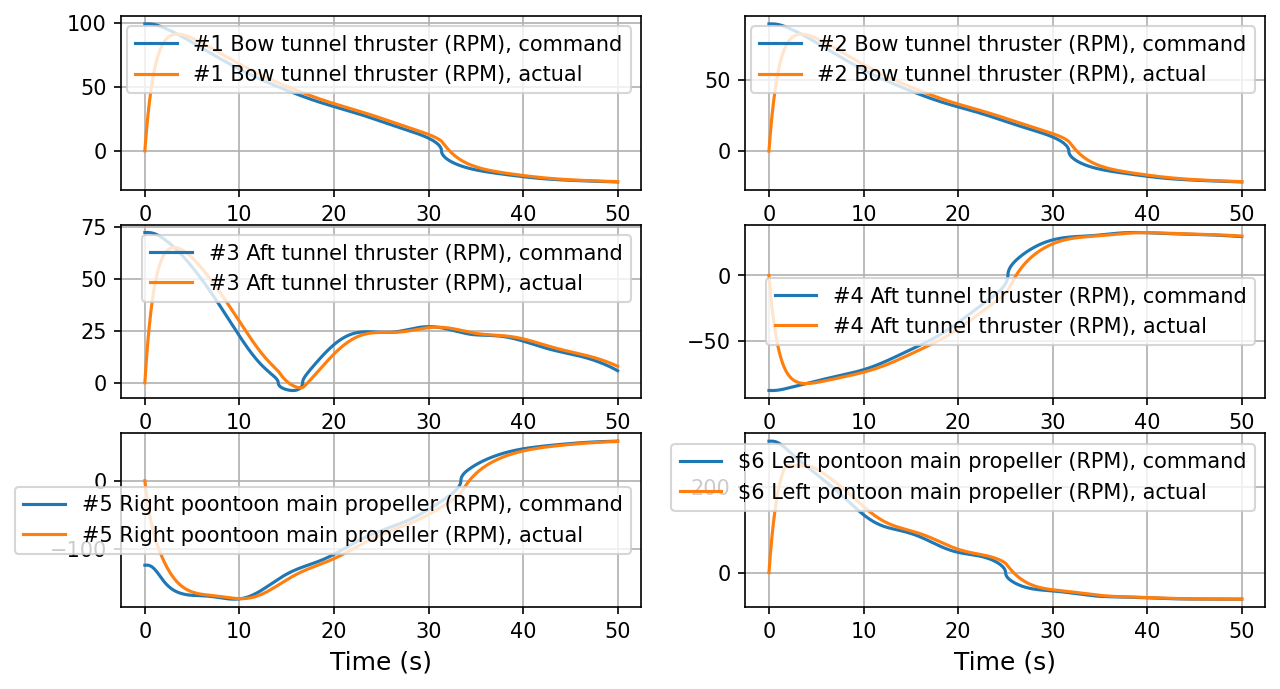

In [122]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [123]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

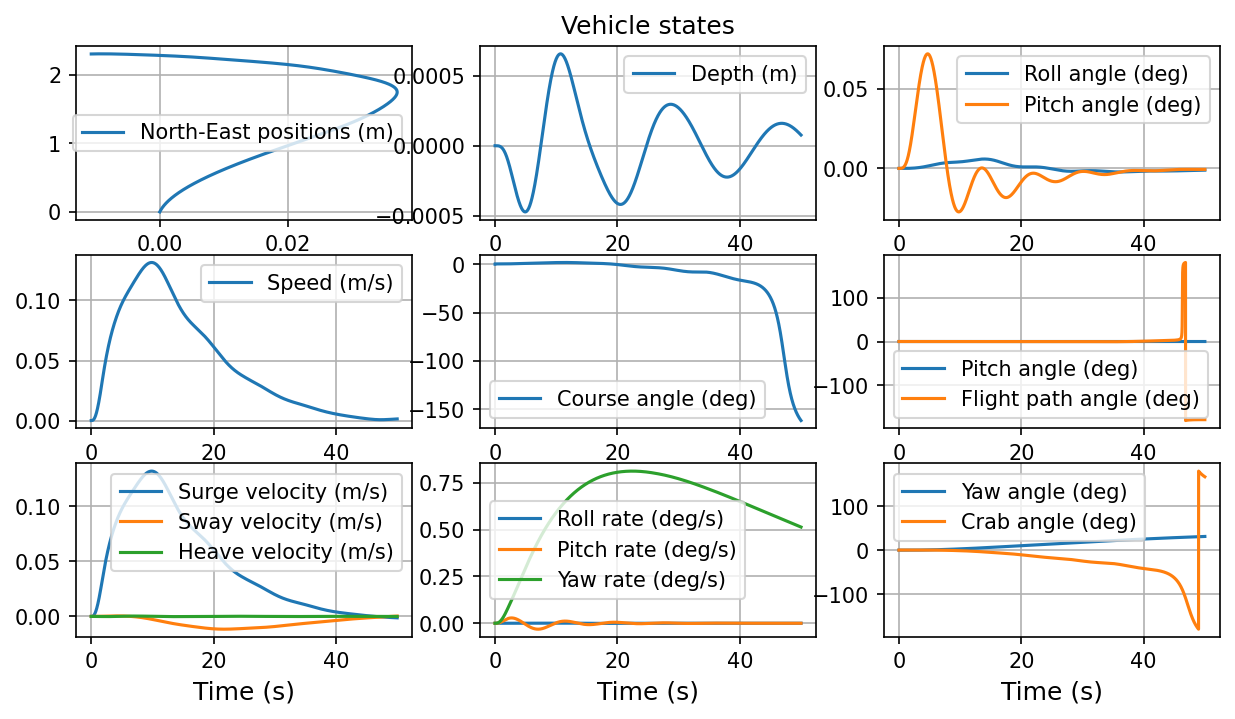

In [124]:
plotVehicleStates(simTime, simData, 3)

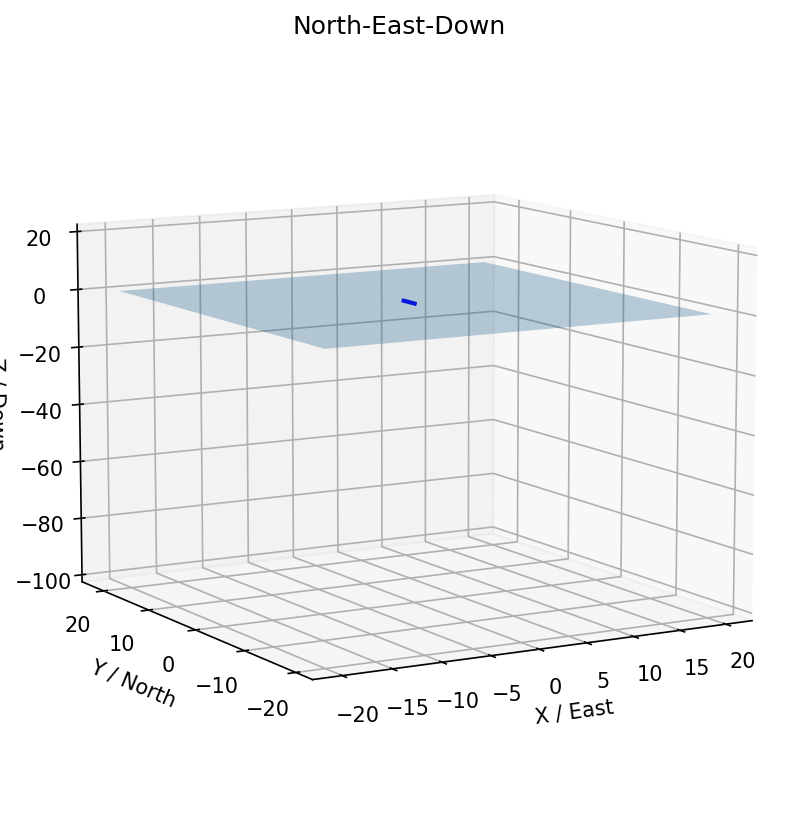

In [125]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [126]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [127]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [128]:
idx=1/0.01

In [129]:
idx

100.0

In [130]:
ssa(simData[:, 3][int(idx)])

1.876148529866839e-07

In [131]:
ssa(simData[:, 4][int(idx)])

3.490806021000381e-05

In [132]:
ssa(simData[:, 5][int(idx)])

8.432223337440092e-05

In [133]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [134]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

### Dynamics

In [135]:
class MyTime:
    def __init__(self):
        self.my_t=0

In [136]:
def grayscott1d(t, Q, force_schedule, T): 
#     print(t,T.my_t,t-T.my_t) 
    if (t-T.my_t)!=0 and abs(t-T.my_t)<1e-10:
        return 'error'
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+1) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
   
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    
    
    fors, mom, angle = PipeForce(x,y,z,n_,force_schedule)
    
    φ,θ,ψ=angle.T

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()


    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T

  
    Z= (
        Z1
        + Z2 
        +Z0
       )

############################################################    
    RRRR=Re_b(Ret)

    
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################      
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)
 
    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t
  
    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

### Calibration

In [137]:
from deap import base
from deap import creator
from deap import tools

import random
import numpy

import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
sys.path.append('../pipelay_vessel_design_optimisation_using_genetic_algorithms/')

In [139]:
import elitism

In [140]:
BOUNDS_LOW = [-100, -100, -100, -100, -100, -100]
BOUNDS_HIGH = [100, 100, 100, 100, 100, 100]

NUM_OF_PARAMS = len(BOUNDS_HIGH)

# Genetic Algorithm constants:
POPULATION_SIZE = 250
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.5   # probability for mutating an individual
MAX_GENERATIONS = 15 
HALL_OF_FAME_SIZE = 5
CROWDING_FACTOR = 20.0  # crowding factor for crossover and mutation

PENALTY_VALUE = 1e10    # fixed penalty for violating a constraint

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)


# define the hyperparameter attributes individually:
for i in range(NUM_OF_PARAMS):
    # "hyperparameter_0", "hyperparameter_1", ...
    toolbox.register("hyperparameter_" + str(i),
                     random.uniform,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])


# create a tuple containing an attribute generator for each param searched:
hyperparameters = ()

for i in range(NUM_OF_PARAMS):
    hyperparameters = hyperparameters + (toolbox.__getattribute__("hyperparameter_" + str(i)),)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator",
                 tools.initCycle,
                 creator.Individual,
                 hyperparameters,
                 n=1)


# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [141]:
def dynamics_for_calibration(individual):
    
    force_schedule_=np.array([individual[0],
                             individual[1],
                             individual[2],
                             individual[3],
                             individual[4],
                             individual[5]])
    
    force_schedule=force_schedule_*(1e-12)
  
    tspan = (0., 50)
#     print(force_schedule)
    T_ = MyTime()
    try:
        us=solve_ivp(grayscott1d,  tspan, q0, 
                     t_eval=[i+1 for i in range(tspan[-1])],
                     args=(force_schedule, T_,))
        if us=='error':
            return PENALTY_VALUE,
    except:
        return PENALTY_VALUE, 
    
    x_ve = x0_[-1]-simData[:, 0]
    y_ve = simData[:, 1]
    z_ve = z0_[-1]-simData[:, 2]
    phi_ve = ssa(simData[:, 3])
    theta_ve = ssa(simData[:, 4])
    psi_v = ssa(simData[:, 5])
#     print(x_ve, y_ve, z_ve )
    
    t=us.t
    
    ans_tt=[]
    for i in t:
        idx = find_nearest(np.array(ans_t),  i) 
        ans_tt.append(idx)


#     print(us.y.T[:,49])
#     print(us.y.T[:,2*node_N+49])
#     print(us.y.T[:,4*node_N+49])
#     print()
    ans = (
#         np.sqrt(np.sum(( us.y.T[:,49]-x_ve[ans_tt])**2))+
#           np.sqrt(np.sum(( us.y.T[:,2*node_N+49]-y_ve[ans_tt])**2))+
          np.sqrt(np.sum(( us.y.T[:,4*node_N+49] - z_ve[ans_tt])**2))
#            +
#           np.sqrt(np.sum(( us.y.T[:,6*node_N+49]-phi_ve[ans_tt] )**2))+
#           np.sqrt(np.sum(( us.y.T[:,8*node_N+49]-theta_ve[ans_tt])**2))+
#           np.sqrt(np.sum(( us.y.T[:,10*node_N+49]-psi_v[ans_tt] )**2))
    )

    return ans,
    

In [142]:
toolbox.register("evaluate", dynamics_for_calibration)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0 / NUM_OF_PARAMS)


In [143]:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    stats.register("avg", numpy.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population,
                                                      toolbox,
                                                      cxpb=P_CROSSOVER,
                                                      mutpb=P_MUTATION,
                                                      ngen=MAX_GENERATIONS,
                                                      stats=stats,
                                                      halloffame=hof,
                                                      verbose=True)


    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    
    
    print()
    print("Double check: ")
  
    force_schedule_=np.array([best[0],
                              best[1],
                              best[2],
                              best[3],
                              best[4],
                              best[5]])
    
    force_schedule=force_schedule_*(1e-12)
  
    tspan = (0., 50)
    T_ = MyTime()
    
    us=solve_ivp(grayscott1d,
                 tspan,
                 q0,
                 t_eval=[i+1 for i in range(tspan[-1])],
                 args=(force_schedule, T_,))
    ans_tt=[]
    t=us.t
    
    for i in t:
        idx = find_nearest(np.array(ans_t),  i) 
        ans_tt.append(idx)
        
    print("-- Best Fitness check = ",
          np.sqrt(np.sum((us.y.T[:,4*node_N+49] - (z0_[-1]-simData[:, 2])[ans_tt])**2))
         )

    
    
    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.savefig("gen.png")
    plt.show()
    return us

In [144]:
# tspan = (0., 50)

gen	nevals	min    	avg    
0  	250   	10.3005	621.566
1  	228   	5.3575 	1236.79
2  	227   	3.12449	1361.55
3  	241   	0.373042	854.25 
4  	227   	0.0896378	496.887
5  	238   	0.0896378	238.11 
6  	230   	0.0896378	194.094
7  	233   	0.0896378	192.947
8  	235   	0.0896378	155.854
9  	234   	0.0896378	235.511
10 	227   	0.0816547	240.337
11 	234   	0.0569138	316.49 
12 	231   	0.0569138	236.749
13 	240   	0.0569138	230.554
14 	236   	0.0569138	254.615
15 	233   	0.0569138	146.123
-- Best Individual =  [-91.27851669645848, -9.257472683368384, -0.4899332658161373, -22.899651335497204, 41.18016717115302, -72.90194510596348]
-- Best Fitness =  0.05691376335714686

Double check: 
-- Best Fitness check =  0.5642264514601552


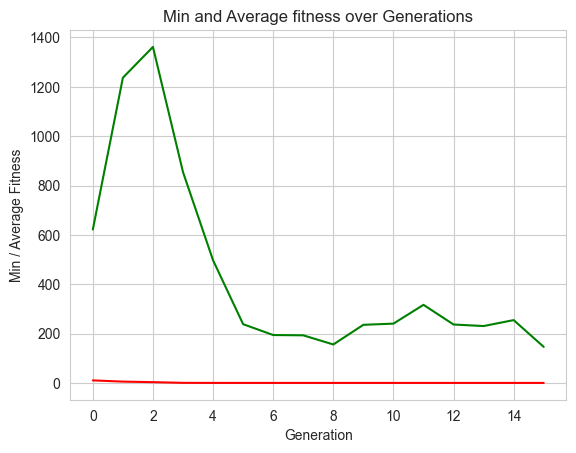

4:37:14.167874


In [145]:
startTime1 = datetime.now()
us=main()
print(datetime.now() - startTime1)

In [147]:
# key takeaway: it needed FEM model. Space frame element approximation is crude, but seems to work.
# The only parameter to tune is force_schedule

### Results

In [148]:
# force_schedule_=np.array([-43.2982957903222, 
#                           -0.7593546925954655,
#                           -0.4953215012745318, 
#                           85.55079188365933,
#                           40.534406006504554, 
#                           -88.01530876944479])
# force_schedule=force_schedule_*(1e-12)
  
# tspan = (0., 50)
# T_ = MyTime()
# us=solve_ivp(grayscott1d,  tspan, q0, t_eval=[i+1 for i in range(tspan[-1])],  args=(force_schedule, T_,))

In [149]:
# T_.my_t

In [150]:
# force_schedule

In [151]:
# fin=us

In [152]:
us

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1  2 ... 49 50]
        y: [[-7.521e-10 -3.001e-09 ... -1.697e-06 -1.765e-06]
            [ 2.256e+02  2.256e+02 ...  2.256e+02  2.256e+02]
            ...
            [ 1.282e-04  1.803e-04 ...  2.766e-03  2.788e-03]
            [ 1.326e-04  1.863e-04 ...  2.826e-03  2.848e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 116
     njev: 0
      nlu: 0

In [153]:
t=us.t

In [154]:
# fin=fin.y.T

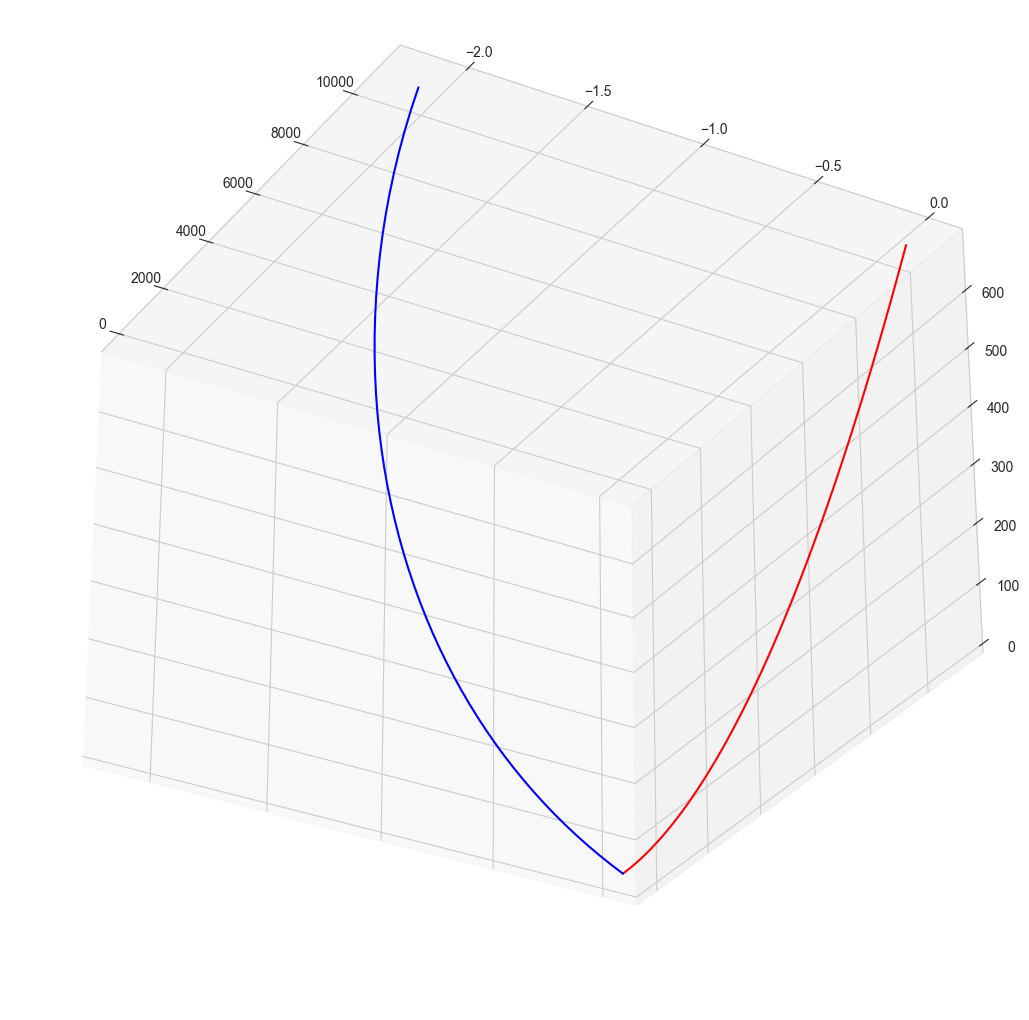

In [155]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=us.y.T[0,[i for i in range(0,node_N)]]
Y0=us.y.T[0,[i for i in range(2*node_N,3*node_N)]]
Z0=us.y.T[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=us.y.T[j,[i for i in range(0,node_N)]]
Y=us.y.T[j,[i for i in range(2*node_N,3*node_N)]]
Z=us.y.T[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [156]:
X,Y,Z

(array([-1.76451448e-06,  2.25564918e+02,  4.51129390e+02,  6.76693050e+02,
         9.02255609e+02,  1.12781685e+03,  1.35337663e+03,  1.57893484e+03,
         1.80449147e+03,  2.03004652e+03,  2.25560005e+03,  2.48115215e+03,
         2.70670295e+03,  2.93225260e+03,  3.15780129e+03,  3.38334922e+03,
         3.60889660e+03,  3.83444364e+03,  4.05999059e+03,  4.28553767e+03,
         4.51108511e+03,  4.73663316e+03,  4.96218202e+03,  5.18773191e+03,
         5.41328303e+03,  5.63883556e+03,  5.86438967e+03,  6.08994550e+03,
         6.31550317e+03,  6.54106277e+03,  6.76662438e+03,  6.99218804e+03,
         7.21775375e+03,  7.44332150e+03,  7.66889123e+03,  7.89446286e+03,
         8.12003626e+03,  8.34561126e+03,  8.57118768e+03,  8.79676527e+03,
         9.02234377e+03,  9.24792285e+03,  9.47350218e+03,  9.69908134e+03,
         9.92465993e+03,  1.01502374e+04,  1.03758134e+04,  1.06013872e+04,
         1.08269583e+04,  1.10525261e+04]),
 array([ 3.29205597e-08, -8.10755397e-02, -1

In [157]:
X0,Y0,Z0

(array([-7.52147413e-10,  2.25564997e+02,  4.51129993e+02,  6.76694989e+02,
         9.02259985e+02,  1.12782498e+03,  1.35338997e+03,  1.57895497e+03,
         1.80451996e+03,  2.03008495e+03,  2.25564994e+03,  2.48121493e+03,
         2.70677992e+03,  2.93234491e+03,  3.15790990e+03,  3.38347489e+03,
         3.60903988e+03,  3.83460487e+03,  4.06016985e+03,  4.28573484e+03,
         4.51129983e+03,  4.73686482e+03,  4.96242981e+03,  5.18799480e+03,
         5.41355979e+03,  5.63912479e+03,  5.86468978e+03,  6.09025477e+03,
         6.31581977e+03,  6.54138477e+03,  6.76694976e+03,  6.99251476e+03,
         7.21807976e+03,  7.44364477e+03,  7.66920977e+03,  7.89477477e+03,
         8.12033978e+03,  8.34590478e+03,  8.57146979e+03,  8.79703479e+03,
         9.02259980e+03,  9.24816481e+03,  9.47372982e+03,  9.69929482e+03,
         9.92485983e+03,  1.01504248e+04,  1.03759898e+04,  1.06015548e+04,
         1.08271198e+04,  1.10526848e+04]),
 array([ 1.75696300e-12, -5.00589035e-06, -9

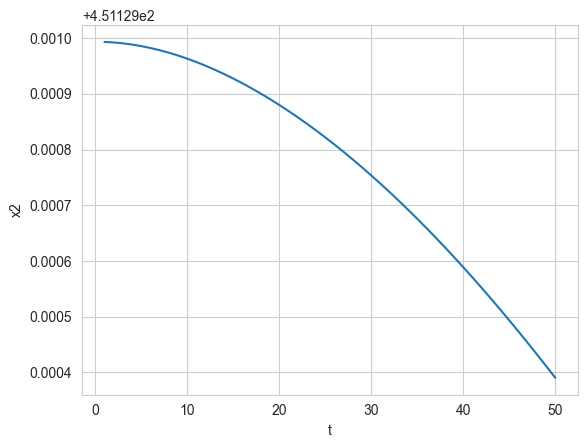

In [158]:
plt.plot(t,us.y.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

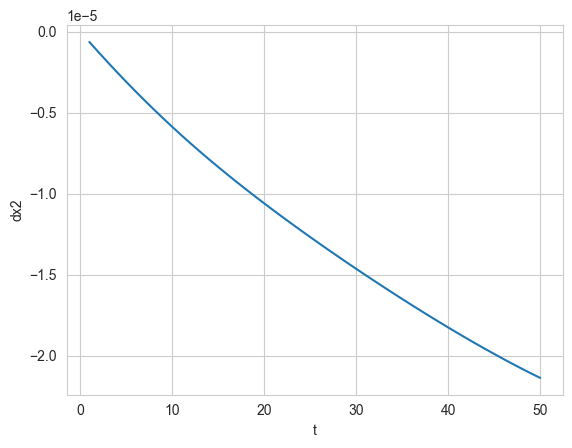

In [159]:
plt.plot(t,us.y.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

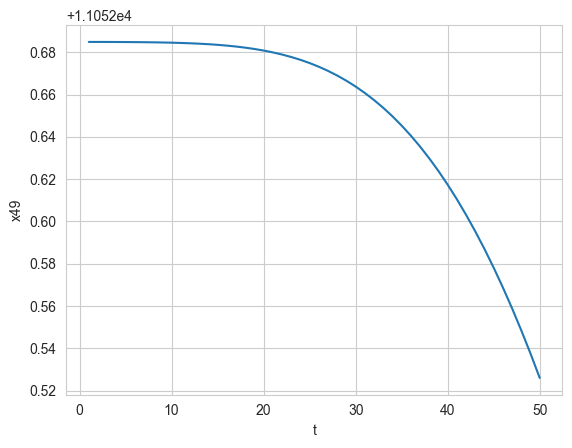

In [160]:
plt.plot(t,us.y.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

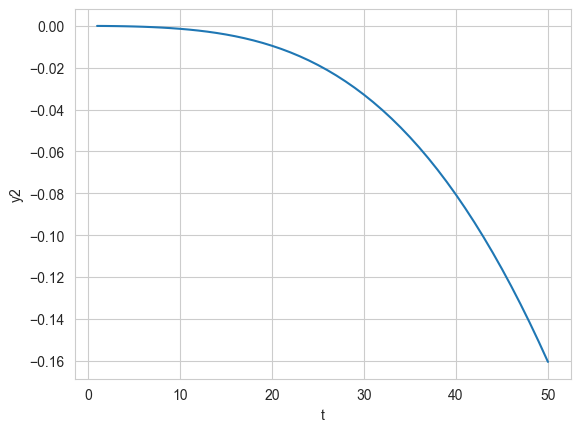

In [161]:
plt.plot(t,us.y.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

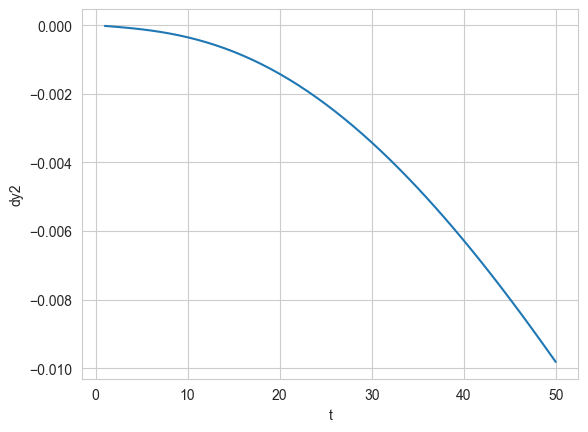

In [162]:
plt.plot(t,us.y.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

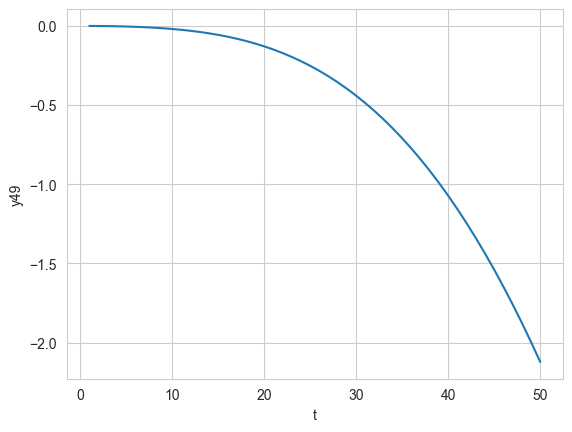

In [163]:
plt.plot(t,us.y.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

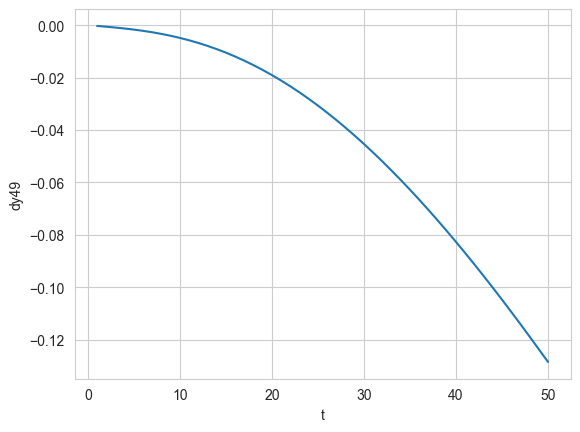

In [164]:
plt.plot(t,us.y.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

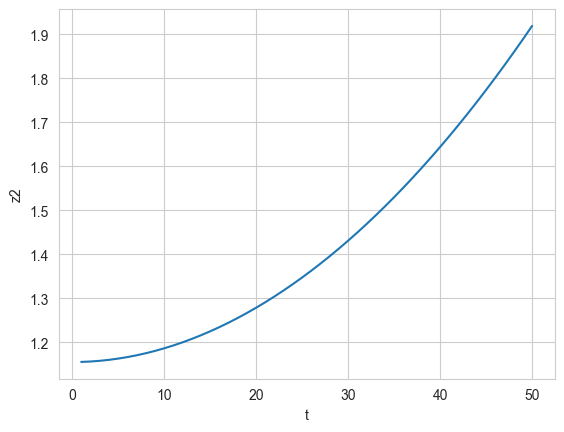

In [165]:
plt.plot(t,us.y.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

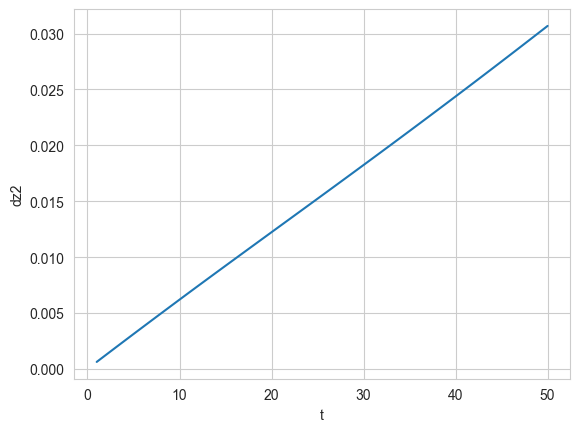

In [166]:
plt.plot(t,us.y.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

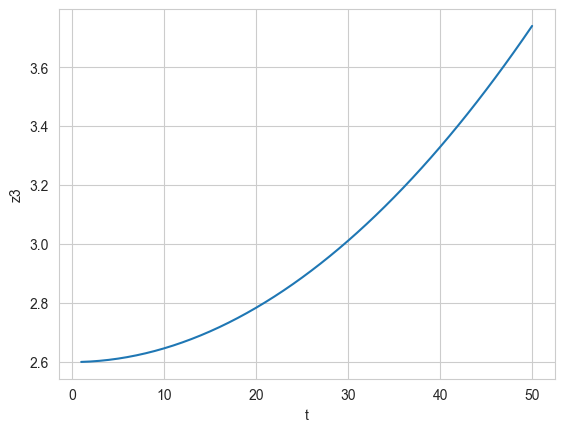

In [167]:
plt.plot(t,us.y.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

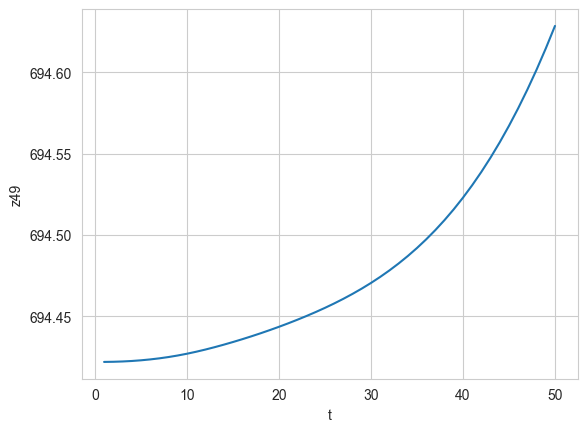

In [168]:
plt.plot(t,us.y.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

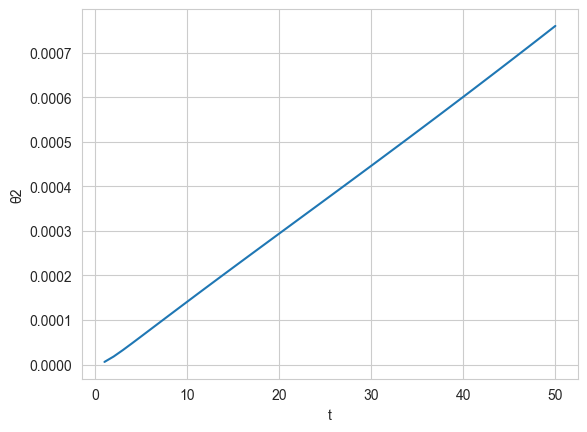

In [169]:
plt.plot(t,us.y.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

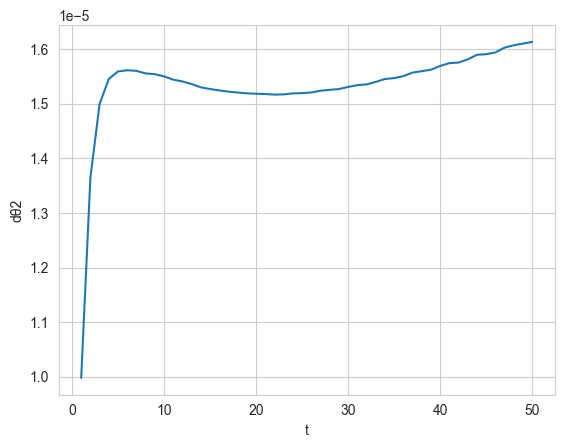

In [170]:
plt.plot(t,us.y.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

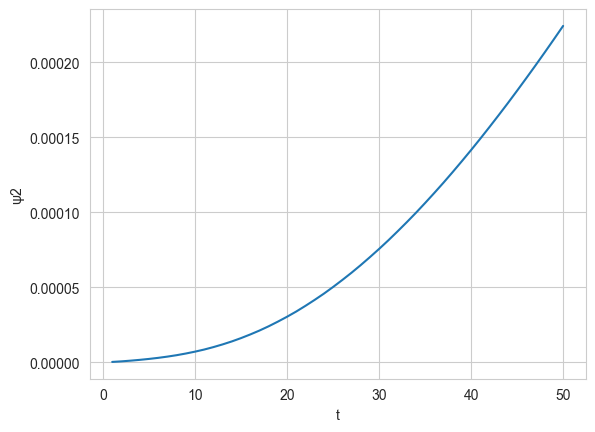

In [171]:
plt.plot(t,us.y.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

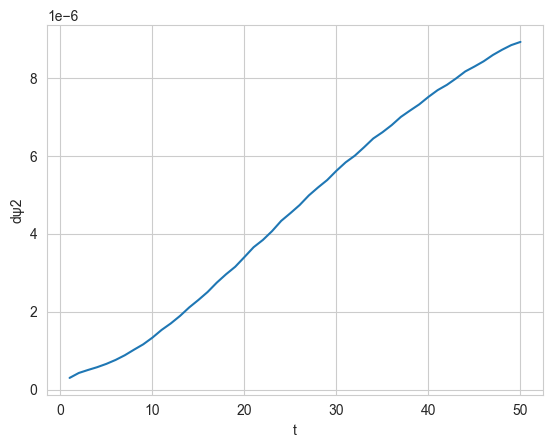

In [172]:
plt.plot(t,us.y.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

In [173]:
ans_tt=[]
t=us.t
for i in t:
    idx = find_nearest(np.array(ans_t),  i) 
    ans_tt.append(idx)
(z0_[-1]-simData[:, 2])[ans_tt]

array([694.4219054 , 694.42198828, 694.42215127, 694.42230883,
       694.42236862, 694.42227537, 694.42203841, 694.42172928,
       694.42144637, 694.42127255, 694.42124332, 694.42133843,
       694.42150191, 694.42167706, 694.42183179, 694.42196118,
       694.42207371, 694.42217494, 694.42225875, 694.42230881,
       694.42230793, 694.42224875, 694.42213931, 694.42200072,
       694.42185931, 694.42173809, 694.42165212, 694.4216069 ,
       694.42159979, 694.42162463, 694.421675  , 694.42174501,
       694.42182824, 694.42191649, 694.42199954, 694.4220662 ,
       694.42210778, 694.42211986, 694.42210286, 694.42206142,
       694.42200305, 694.42193651, 694.42187043, 694.42181232,
       694.42176807, 694.42174162, 694.42173485, 694.42174742,
       694.42177679, 694.42181855])

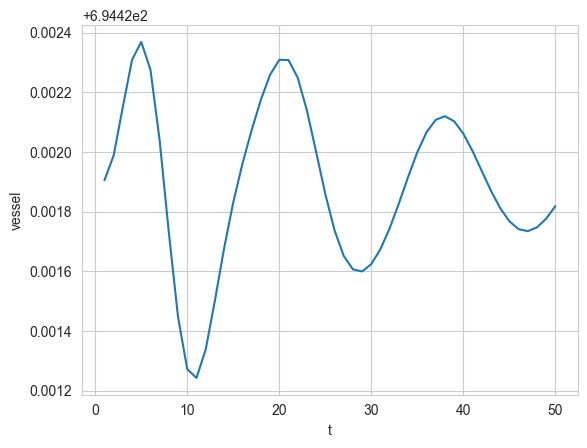

In [176]:
plt.plot(t,(z0_[-1]-simData[:, 2])[ans_tt] ,'-')
plt.xlabel('t')
plt.ylabel('vessel')
plt.show()

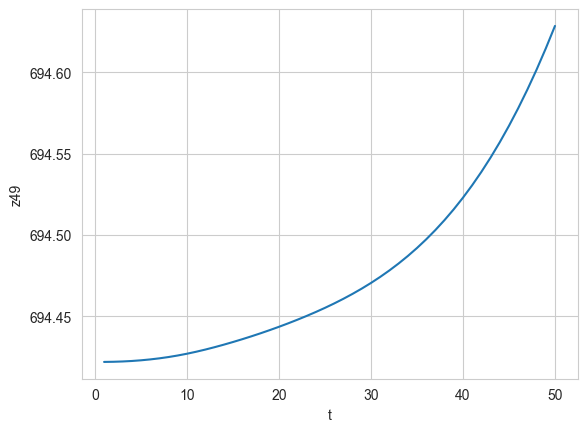

In [177]:
us.y.T[:,4*node_N+49]
plt.plot(t,us.y.T[:,4*node_N+49],'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [178]:
np.sqrt(np.sum(((us.y.T[:,4*node_N+49]-(z0_[-1]-simData[:, 2])[ans_tt])**2)))

0.5642264514601552

In [179]:
ans_tt

[100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700,
 2800,
 2900,
 3000,
 3100,
 3200,
 3300,
 3400,
 3500,
 3600,
 3700,
 3800,
 3900,
 4000,
 4100,
 4200,
 4300,
 4400,
 4500,
 4600,
 4700,
 4800,
 4900,
 5000]

In [180]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])